In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
from scipy.stats import norm
import matplotlib.mlab as mlab
from lmfit.models import GaussianModel

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ADC                  | std::vector<int16_t>     | AsJagged(AsDtype('>i2'), he...
EventNumber          | int32_t                  | AsDtype('>i4')
TriggerTimeStamp     | uint64_t                 | AsDtype('>u8')
PCTimeStamp          | uint64_t                 | AsDtype('>u8')


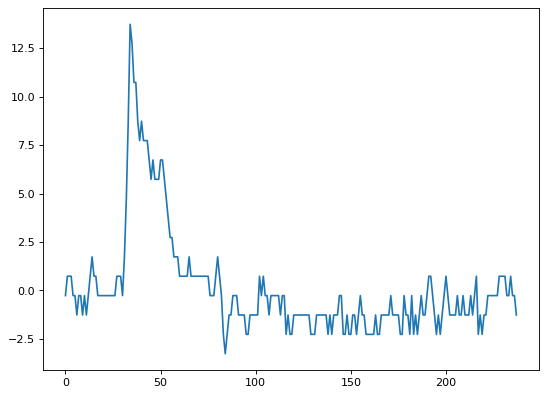

In [65]:
file_path="ROOT/RUN105_ch0.root"


file = uproot.open(file_path)
file.keys()
tree = file["IR02;1"] 

tree.show()
evts=tree["ADC"].array().to_numpy().astype(float);


#Event process
Amp = []
T   = []
Ped = []
Q   = []
count=0;

for i in evts:
    ped = np.mean(-i[0:30])
    wvf = -(i+ped)
    tmax   = np.argmax(-i)
    amax   = np.max(wvf)
    q   = np.mean(wvf[30:72])
    T.append(tmax)
    Amp.append(amax)
    Ped.append(ped)
    Q.append(q)
    evts[count]=wvf
    count+=1

#Print a waveform, pedestal is already substracted
sample=evts[4];
plt.figure(figsize=(8, 6), dpi=80);
plt.plot(evts[4])


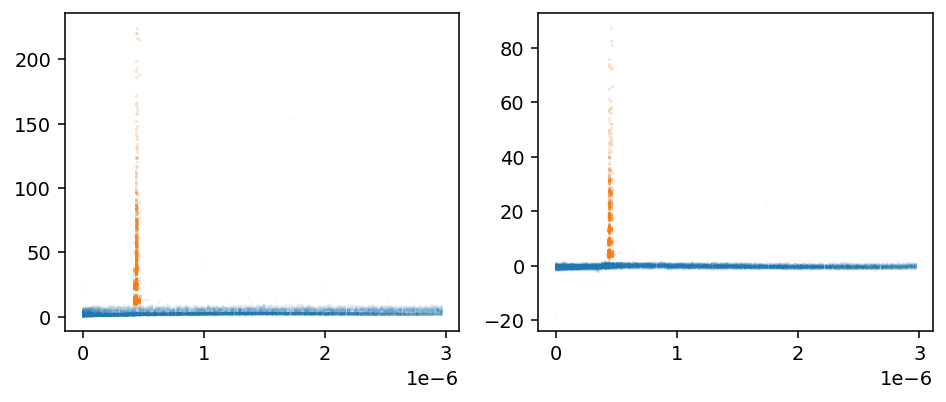

In [66]:
# %matplotlib widget

Amp=np.array(Amp)
Q  =np.array(Q)
T2=np.array(T)*12.5*1e-9
# plt.plot(T2,Amp,marker='.',markersize=.1,linestyle="")

cut1=(T2>0.4e-6) & (T2<0.5e-6)
cut2=Amp>0
cut3=Q>2

cuts=cut1*cut2*cut3

plt.figure(figsize=(8, 3), dpi=140);
plt.subplot(1,2,1)

plt.plot(T2,Amp,marker='.',markersize=.05,linestyle="")
plt.plot(T2[cuts],Amp[cuts],marker='o',markersize=0.1,linestyle="")

plt.subplot(1,2,2)
plt.plot(T2,Q,marker='.',markersize=.05,linestyle="")
plt.plot(T2[cuts],Q[cuts],marker='o',markersize=0.1,linestyle="")



In [67]:
# # Uncomment to check pedestal is well computed
# for i in range(1,50):
#     plt.plot((evts[cuts][i]))
#     plt.grid()
#     plt.show()

(1, 200.0)

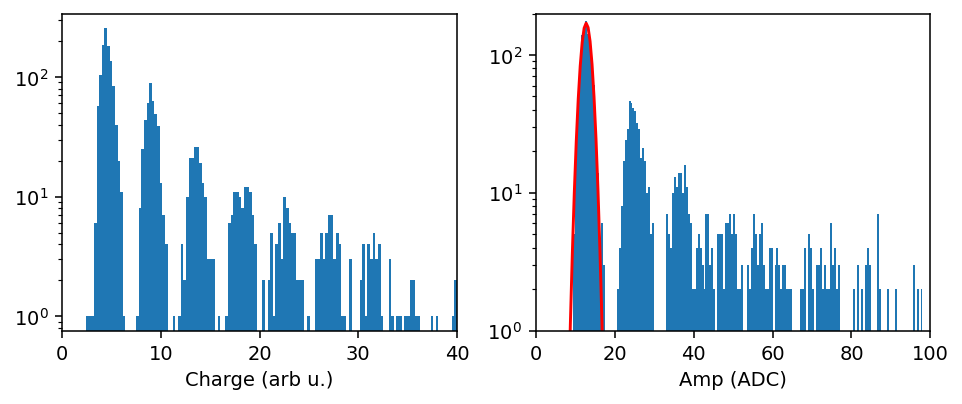

In [68]:
%matplotlib inline

plt.figure(figsize=(8, 3), dpi=140);

plt.subplot(1,2,1)

plt.hist(Q[cuts],150,range=[0,40]);
plt.semilogy()
plt.xlim([0,40])
plt.xlabel('Charge (arb u.)')

plt.subplot(1,2,2)
n, bins, patches=plt.hist(Amp[cuts],range=[0,100],bins=200);
plt.semilogy()
plt.xlim([0,100])
plt.xlabel('Amp (ADC)')

# Skewed Gaussian fit
model = GaussianModel()
params = model.make_params(amplitude=250, center=12, sigma=1)
result = model.fit(n[15:40], params, x=bins[15:40]+0.25)
plt.plot(bins[15:40]+0.25, result.best_fit, color = 'red', label = 'Gaussian fit')
plt.ylim([1,2e2])


In [7]:
%matplotlib 
cuts2=cuts*(Q<7)

avw=np.zeros(len(sample))

evts_1PE=evts[cuts2]
for i in range(len(evts_1PE)):
        avw+=evts_1PE[i]

plt.figure(figsize=(8, 6), dpi=80);

plt.plot(avw/max(avw))
#check average waveform and gaussian fit to amplitude histogram give the same amplitude for the 1PE response
print("Aver waveform:", max(avw)/len(evts_1PE))
print("Amp spect fit:",result.params["center"].value,r"+/-",result.params["center"].stderr)

avw=np.zeros(len(sample))
for i in range(len(evts)):
    if cuts[i]:
        avw+=evts[i]
plt.plot(avw/max(avw))

plt.grid()
plt.legend(['1PE events only','All Q$\geq 1PE$ events'])

Using matplotlib backend: Qt5Agg
Aver waveform: 12.597537703908888
Amp spect fit: 12.76498544186287 +/- 0.03160135149439764


In [8]:
plt.figure(figsize=(8, 6), dpi=70);
x=np.arange(1,239)
# plt.hist2d(x=np.tile(x, evts[cuts].shape[0]), y=-evts[cuts].ravel(), bins=(200, 200),cmin=1);
plt.hist2d(x=np.tile(x, evts[cuts].shape[0]), y=evts[cuts].ravel() ,cmin=0,bins=(238, 70),range=[[0,238],[-20,50]],cmap="jet");



Expected number of arriving photons

$P_{n} = \frac{{{\left\vert \alpha \right\vert}^{2n}}}{n!} e^{{-\left\vert \alpha \right\vert}^2} = \frac{{\langle n \rangle}^{n}}{n!} e^{-\langle n \rangle}\quad n=1,2,3...$

Gauss distribution (each peak)

$f(x) = \frac{1}{\sigma \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$

Both effects:

$\sum_{n=0}^\infty = \frac{\mu^n e^{-\mu}}{n!}\frac{1}{\sigma_1\sqrt{2\pi}}e^{-\frac{(x-nQ_1)^2}{2\sigma_1^2}}$·

(0.001, 1)

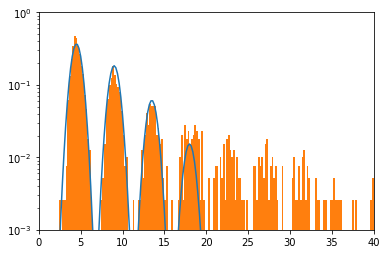

In [50]:
%matplotlib inline

Amp_1PE=result.params["center"].value

### Monte carlo

#Arrivin photons
mean_photons=1
#gaussian distributions
mu=4.5
sigma=.4

x=np.arange(0,100,.2)
y=np.zeros(len(x))
for n in range(1,5):
    y+=mean_photons**n*np.exp(-mean_photons)/np.math.factorial(n)*(1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x-n*mu)**2/(2*sigma)**2)
plt.plot(x,y)
plt.semilogy()
plt.hist(Q[cuts],500,range=[0,100],density=True);
plt.xlim([0,40])
plt.ylim([1e-3,1])



In [52]:
%matplotlib
plt.plot(Amp[cuts],Q[cuts],marker='o',markersize=0.1,linestyle="")


Using matplotlib backend: Qt5Agg
